In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve , roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
col_names = ['location' , 'country' , 'gender' , 'age' , 'vis_wuhan' , 'from_wuhan' , 'symptom1' , 'symptom2' , 'symptom3', 'symptom4' , 'symptom5' , 'symptom6' , 'diff_sym_hos']
data = pd.read_csv("data.csv", skiprows=1, header=None, names=col_names)
data.head(10)

,,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0
5,23,8,0,44.0,0,1,14,31,19,12,3,1,0,0
6,105,8,1,34.0,0,1,14,31,19,12,3,1,0,0
7,13,8,1,37.0,1,0,14,31,19,12,3,1,6,0
8,13,8,1,39.0,1,0,14,31,19,12,3,1,5,0
9,13,8,1,56.0,1,0,14,31,19,12,3,1,4,0


In [ ]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [ ]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None

        self.is_leaf = True
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

    def predict_proba(self, row):
      if self.is_leaf:
          return self.probabilities()
      else:
          if row[self.column] <= self.split_point:
              return self.children[0].predict_proba(row)
          else:
              return self.children[1].predict_proba(row)

In [ ]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [ ]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_2 <= 65.0 ? 0.10240296690854028
 left:X_0 <= 3.0 ? 0.016428486046288028
  left:X_0 <= 1.0 ? 0.15123456790123457
    left:0.0
    right:X_11 <= 0.0 ? 0.21875
        left:1.0
        right:0.0
  right:X_2 <= 58.0 ? 0.009298352800239523
    left:X_2 <= 56.0 ? 0.00015011273288238107
        left:0.0
        right:0.0
    right:X_11 <= 3.0 ? 0.11162646876932586
        left:0.0
        right:1.0
 right:X_1 <= 0.0 ? 0.04626649406557848
  left:X_2 <= 75.0 ? 0.1266323703996834
    left:X_6 <= 7.0 ? 0.07985803016858928
        left:0.0
        right:1.0
    right:1.0
  right:X_0 <= 24.0 ? 0.015279747026637314
    left:X_2 <= 66.0 ? 0.020056349786079453
        left:0.0
        right:1.0
    right:X_2 <= 77.0 ? 0.17777777777777787
        left:1.0
        right:0.0


In [ ]:
Y_pred = classifier.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9364161849710982

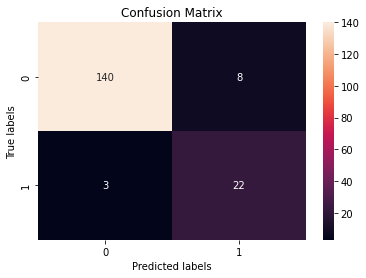

In [ ]:
#Calculating Prediction
Y_pred = classifier.predict(X_test)
#print('Predicted Value for SVM_model is : ' , yPred[:10])

#----------------------------------------------------
#Calculating Confusion Matrix
CM = confusion_matrix(Y_test, Y_pred)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [ ]:
#Calculating classification Report :  

ClassificationReport = classification_report(Y_test, Y_pred)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       148
           1       0.73      0.88      0.80        25

    accuracy                           0.94       173
   macro avg       0.86      0.91      0.88       173
weighted avg       0.94      0.94      0.94       173



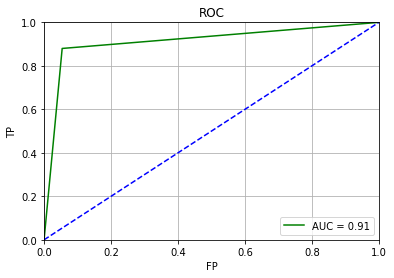

In [ ]:
#Calculating Area Under the Curve with predict probapility:
fpr, tpr, threshold = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TP')
plt.xlabel('FP')
plt.title('ROC')
plt.grid()